# Commands in Colab

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!mkdir /content/models

In [21]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [3]:
device

'mps'

# Load datasets

In [4]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

# Create class for collecting data

In [5]:
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor(labels[1]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

In [12]:
temp = PriceDataset(features, labels)
in_features = len(temp[0][0])

# Build the model

In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, neurons):
        super(ResidualBlock, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, neurons),
                                    nn.ReLU(),
                                    nn.Linear(neurons, neurons),
                                    nn.ReLU(),
                                    nn.Linear(neurons, neurons),
                                    nn.ReLU(),
                                    nn.Linear(neurons, neurons),
                                    nn.ReLU(),
                                    nn.Linear(neurons, in_features),
                                    nn.BatchNorm1d(in_features))
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.hidden(x)
        out += x
        out = self.relu(out)

        return out


class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(ResidualBlock(in_features, 512),
                                    ResidualBlock(in_features, 1024),
                                    ResidualBlock(in_features, 1024),
                                    ResidualBlock(in_features, 256),
                                    ResidualBlock(in_features, 128))
        self.price = nn.Sequential(nn.Linear(in_features, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

In [28]:
model = PredictPrice(in_features)
torchinfo.summary(model, input_size=(1, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictPrice                             --                        --
├─Sequential: 1-1                        [1, 51]                   --
│    └─ResidualBlock: 2-1                [1, 51]                   --
│    │    └─Sequential: 3-1              [1, 51]                   840,857
│    │    └─ReLU: 3-2                    [1, 51]                   --
│    └─ResidualBlock: 2-2                [1, 51]                   --
│    │    └─Sequential: 3-3              [1, 51]                   3,254,425
│    │    └─ReLU: 3-4                    [1, 51]                   --
│    └─ResidualBlock: 2-3                [1, 51]                   --
│    │    └─Sequential: 3-5              [1, 51]                   3,254,425
│    │    └─ReLU: 3-6                    [1, 51]                   --
│    └─ResidualBlock: 2-4                [1, 51]                   --
│    │    └─Sequential: 3-7              [1, 51]                  

# Data standardization

In [29]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

# Train the model
## Prepare the data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.2)

## Cross validation

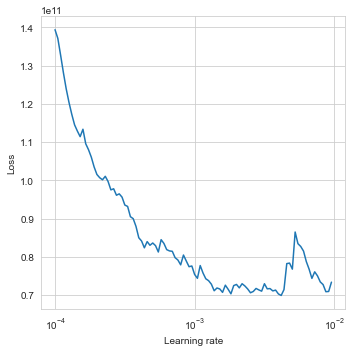

In [33]:
model = PredictPrice(len(x_train.iloc[0]))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
temp = TrainValidate(model, loss_fn, optimizer)

temp_data = PriceDataset(x_train, y_train)
temp_loader = DataLoader(temp_data, batch_size=16, shuffle=True, drop_last=True)

result, fig = temp.test_lr_range(temp_loader, 1e-2, 100)

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/all_complex_full_epoch_1000_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 0.856	train_loss: 26090115072.000	(6.97s - 8134.60s remaining)))

KeyboardInterrupt: 